feature engineering

1. load data
2. identify outcome and features
3. feature engineering
4. feature selection
5. EDA for engineered features

In [14]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn import set_config

from sklearn.model_selection import train_test_split


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

1. load data

In [2]:
readmit_data = pd.read_csv("healthcare_patient_journey.csv")
readmit_data.head()

,patient_id,age,gender,chronic_condition,admission_type,department,wait_time_min,length_of_stay_days,procedures_count,medication_count,complications,discharge_status,readmitted_30d,total_cost_€,satisfaction_score
0,1,69,male,0,scheduled,Neurology,41,2,0,3,1,referred,1,1440,2
1,2,38,male,0,emergency,Oncology,17,3,1,2,0,recovered,0,2060,3
2,3,81,male,0,scheduled,Neurology,40,2,3,2,0,recovered,0,2110,3
3,4,67,female,1,emergency,ER,7,4,5,9,0,recovered,0,4070,3
4,5,88,male,1,emergency,Cardiology,34,3,7,5,0,recovered,1,3800,3


2. identify outcome and features

In [3]:
# identify outcome
outcome = "readmitted_30d"

# identify feature types
numeric_features = readmit_data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = readmit_data.select_dtypes(include=['object', 'category', 'str']).columns

print("Outcome:", outcome)
print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

Outcome: readmitted_30d
Numeric: Index(['patient_id', 'age', 'chronic_condition', 'wait_time_min',
       'length_of_stay_days', 'procedures_count', 'medication_count',
       'complications', 'readmitted_30d', 'total_cost_€',
       'satisfaction_score'],
      dtype='str')
Categorical: Index(['gender', 'admission_type', 'department', 'discharge_status'], dtype='str')


3. feature engineering

In [4]:
def engineer_features(X: pd.DataFrame) -> pd.DataFrame:
    X = X.copy()

    # drop patient ID
    X = X.drop(columns=["patient_id"], errors="ignore")

    # age features
    X["is_elderly"] = (X["age"] >= 65).astype(int)
    X["age_group"] = pd.cut(
        X["age"],
        bins=[0, 40, 65, 80, 120],
        labels=["young", "adult", "senior", "elderly"]
    )

    # utilization intensity features
    X["procedures_per_day"] = X["procedures_count"] / (X["length_of_stay_days"] + 1)
    X["meds_per_day"] = X["medication_count"] / (X["length_of_stay_days"] + 1)

    # length of stay features
    X["log_LOS"] = np.log1p(X["length_of_stay_days"])
    X["long_stay"] = (X["length_of_stay_days"] > 7).astype(int)

    # cost feature
    X["cost_per_day"] = X["total_cost_€"] / (X["length_of_stay_days"])

    # satisfaction feature
    X["low_satisfaction"] = (X["satisfaction_score"] <= 3).astype(int)

    return X

set_config(transform_output="pandas")
feature_eng = FunctionTransformer(engineer_features)

4. feature selection

In [20]:
# select by dtype
def get_column_types(X_fit: pd.DataFrame):
    numeric_selector = selector(dtype_include=np.number)
    categorical_selector = selector(dtype_include=['object','category'])

    numeric_cols = numeric_selector(X_fit)
    categorical_cols = categorical_selector(X_fit)

    return numeric_cols, categorical_cols

# separate outcome
X = readmit_data.drop(columns=[outcome], errors="ignore")
y = readmit_data[outcome]

# fit feature engineering
X_fe = feature_eng.fit_transform(X) # fit() learns parameters, transform() applies learned parameters to data
num_cols, cat_cols = get_column_types(X_fe)

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['age', 'chronic_condition', 'wait_time_min', 'length_of_stay_days', 'procedures_count', 'medication_count', 'complications', 'total_cost_€', 'satisfaction_score', 'is_elderly', 'procedures_per_day', 'meds_per_day', 'log_LOS', 'long_stay', 'cost_per_day', 'low_satisfaction']
Categorical columns: ['gender', 'admission_type', 'department', 'discharge_status', 'age_group']


5. EDA for engineered features

In [21]:
df = X_fe.copy()
df[outcome] = y.values

fe_cols_num = ['is_elderly', 'procedures_per_day', 'meds_per_day', 'log_LOS', 'long_stay', 'cost_per_day', 'low_satisfaction']
fe_cols_cat = ['age_group']

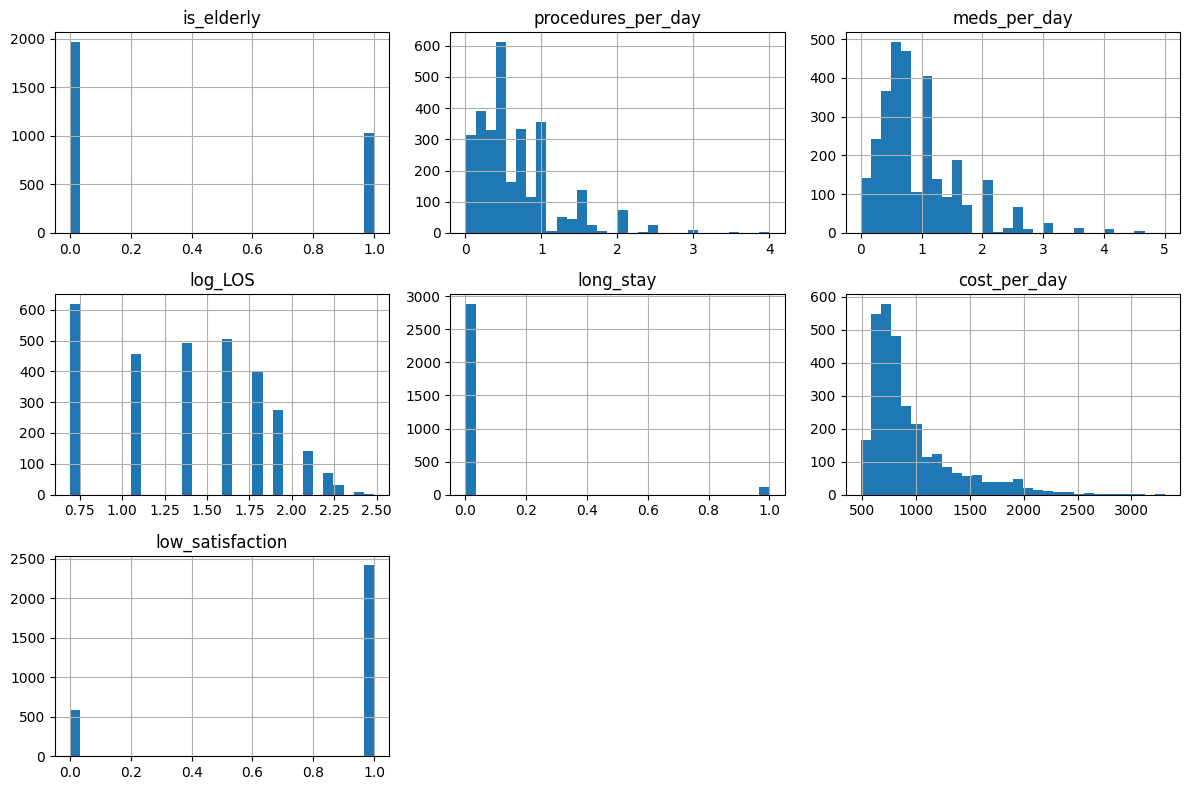

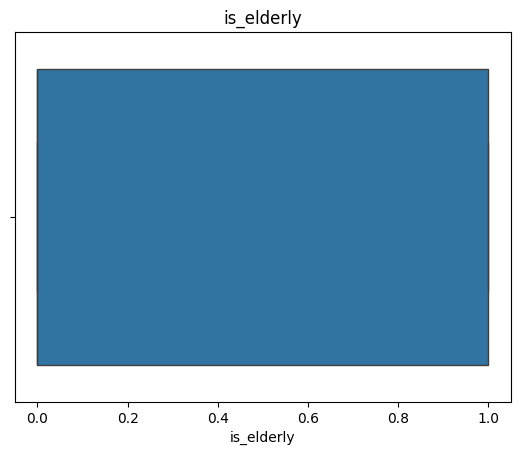

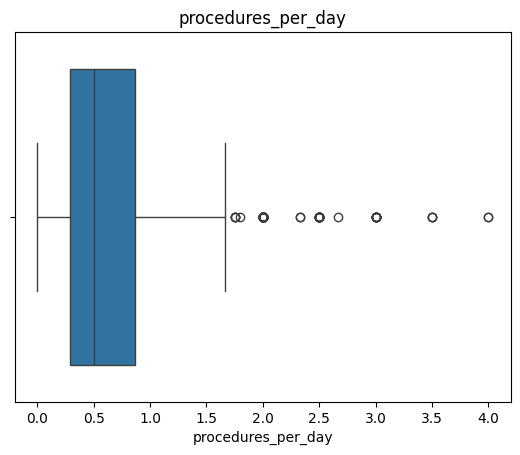

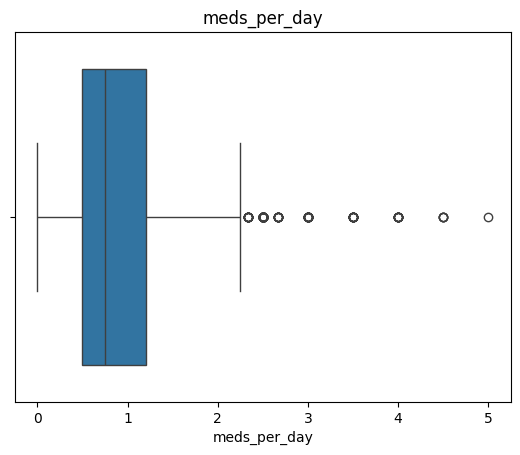

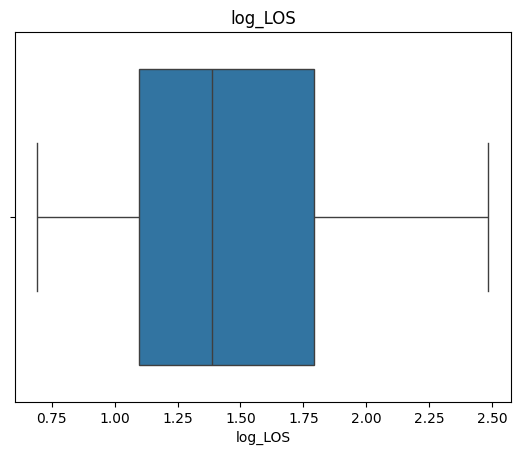

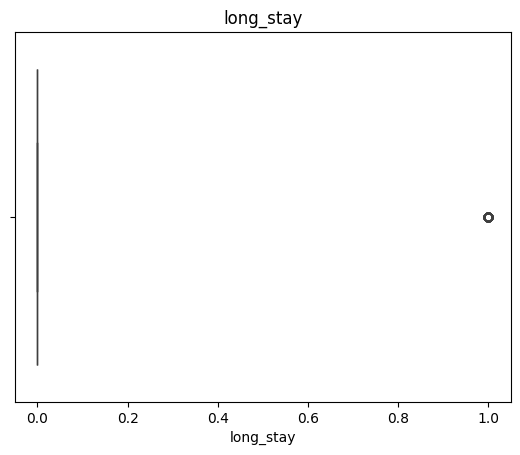

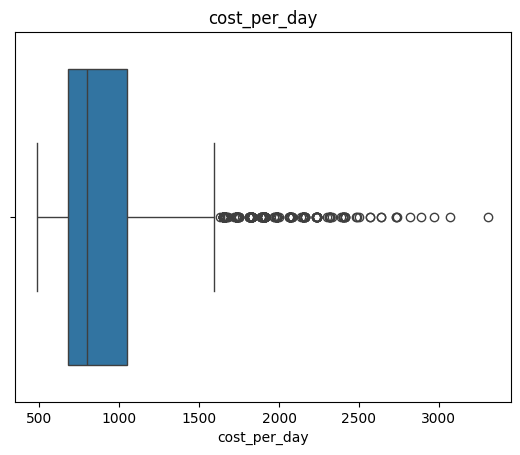

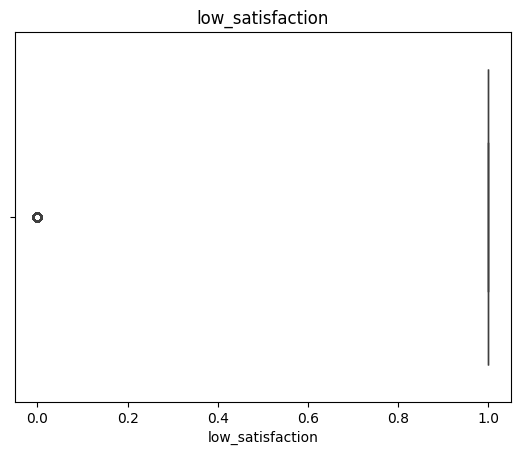

In [22]:
# numeric

# frequency distribution
df[fe_cols_num].hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()

# boxplots (for outliers)
for col in fe_cols_num:
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()

age_group
adult      1031
young       978
senior      634
elderly     357
Name: count, dtype: int64


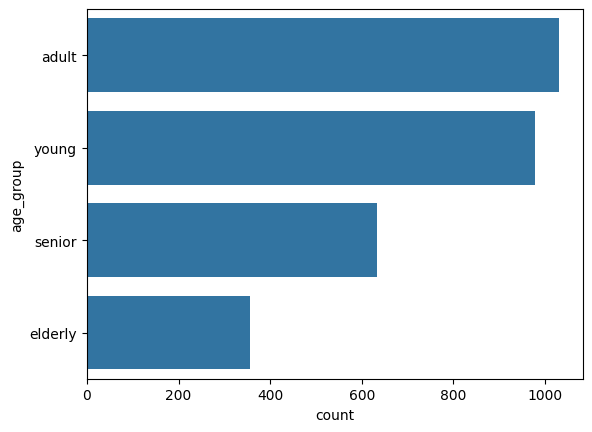

In [23]:
# categorical
for col in fe_cols_cat:
    print(df[col].value_counts())
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.show()

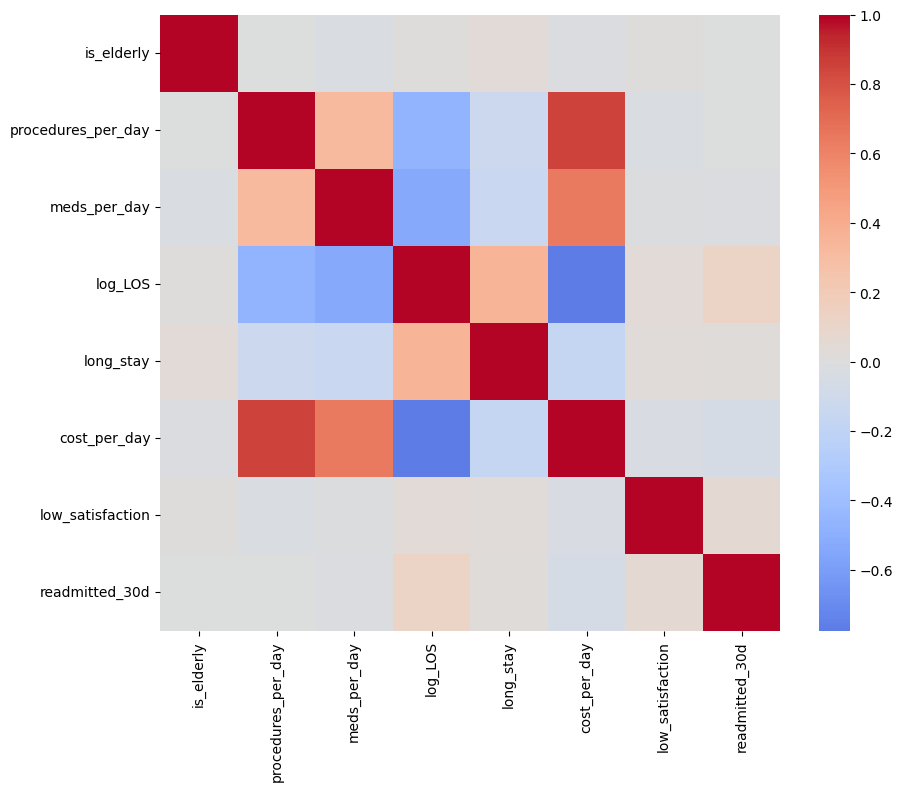

readmitted_30d        1.000000
log_LOS               0.121626
low_satisfaction      0.061956
long_stay             0.021707
procedures_per_day   -0.001206
is_elderly           -0.004484
meds_per_day         -0.018571
cost_per_day         -0.057223
Name: readmitted_30d, dtype: float64

In [27]:
# correlation matrix
corr = df[fe_cols_num + [outcome]].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.show()

# correlation with outcome
corr[outcome].sort_values(ascending=False)

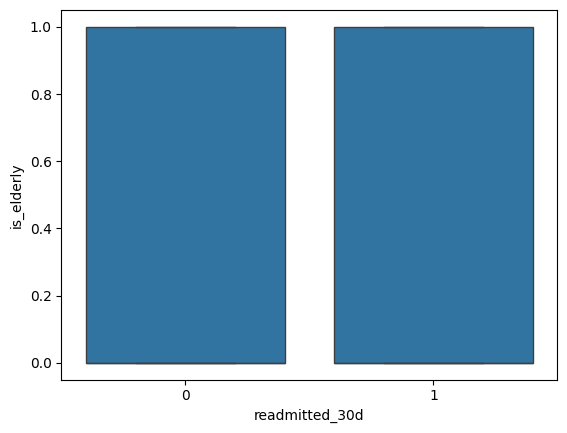

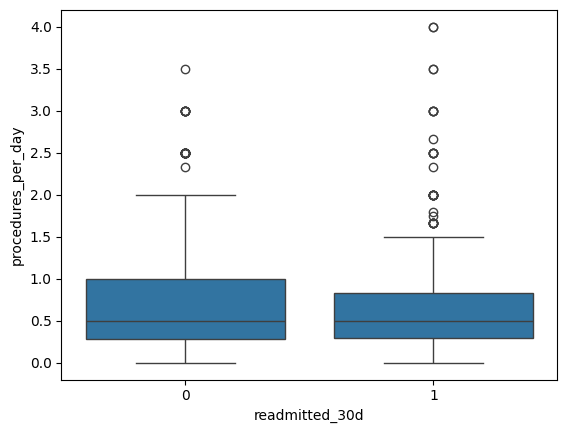

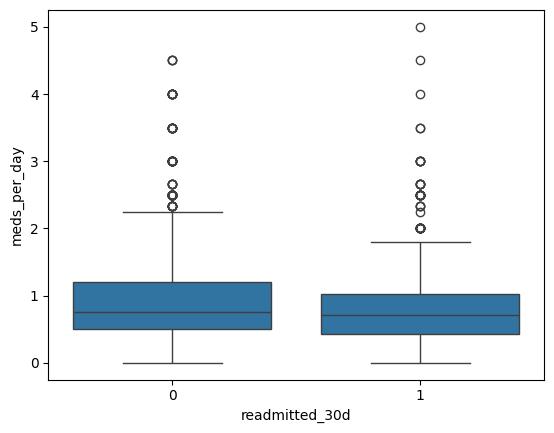

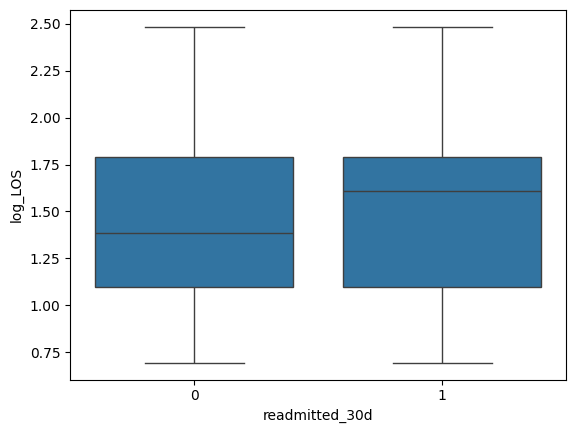

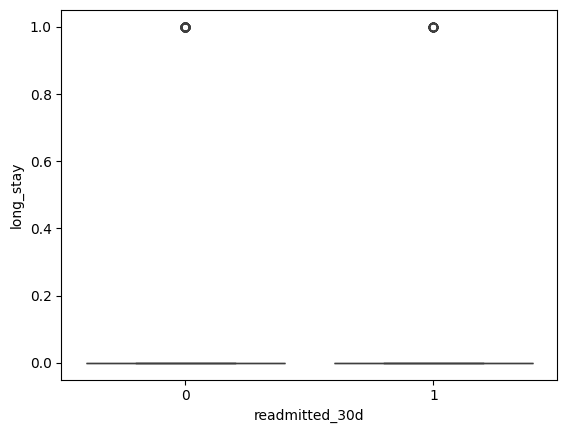

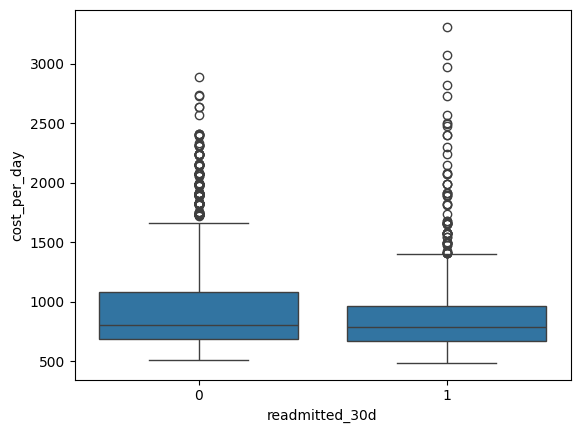

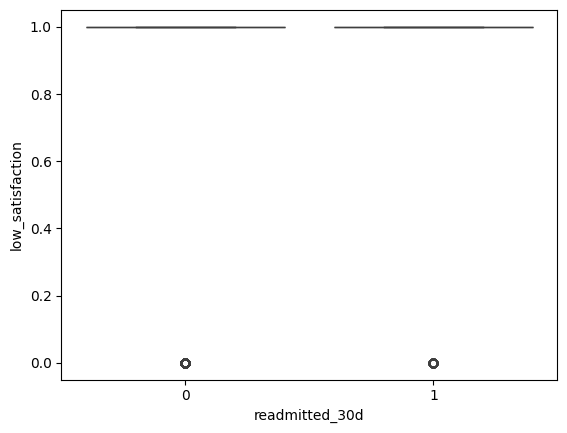

readmitted_30d         0         1
age_group                         
young           0.779141  0.220859
adult           0.744908  0.255092
senior          0.752366  0.247634
elderly         0.809524  0.190476


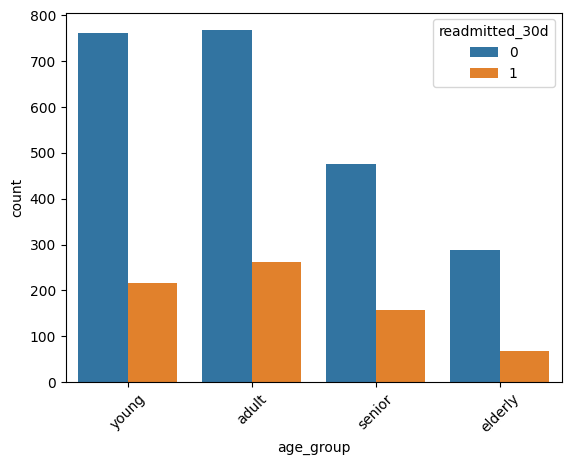

In [28]:
# feature vs. outcome

# numeric
for col in fe_cols_num:
    sns.boxplot(x=df[outcome], y=df[col])
    plt.show()

# categorical 
for col in fe_cols_cat:
    prop_table = pd.crosstab(df[col], df[outcome], normalize="index")
    print(prop_table)
    sns.countplot(x=col, hue=outcome, data=df)
    plt.xticks(rotation=45)
    plt.show()